# Análise de explosões solares
------

O clima e o tempo espacial são áreas que abrangem o estudo do Sol, dos ventos solares, do campo magnético e dos impactos financeiros do ambiente espacial.  Prever fenômenos solares nos permite executar ações que minimizam o impacto de eventos solares nos sistemas de telecomunicação e sistemas de distribuição de energia. Contudo, a física que determina a dinâmica solar é complexa e requer muita informação para ser analisada. Além disso, os mecanismos que geram uma explosão solar são pouco compreendidos [(Hudson, 2011)](https://link.springer.com/article/10.1007/s11214-010-9721-4).

![title](imgs/carrington-sunspots-data.jpg)
<center>Fonte:<a href="https://www.abc.net.au/news/2014-09-12/how-solar-storms-affect-earth/5740454">https://www.abc.net.au/news/2014-09-12/how-solar-storms-affect-earth/5740454</a></center>

O desafio deste trabalho é analisar séries temporais do Sol, com o intuito de prever explosões solares altamente energéticas.

Neste trabalho foi utilizado a biblioteca [SunPy](http://adsabs.harvard.edu/abs/2015CS%26D....8a4009S) para obtenção de imagens e séries temporais de raio-X do Sol.


# 1. Testes

O código abaixo é idêntico ao mostrado [aqui](https://docs.sunpy.org/en/latest/_downloads/3a8b152e871f5ccd2772588a970a8202/goes_hek_m25.py). O objetivo é apenas testar a biblioteca SunPy. 

In [1]:
#bibliotecas gerais:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import fft

#tensorflow:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU,LSTM, Embedding, Dropout
from tensorflow.keras.optimizers import RMSprop, SGD

# Para tratar dos dados solares:
import sunpy.map
import calendar
from datetime import datetime
from sunpy.timeseries import TimeSeries
from sunpy.time import TimeRange, parse_time
from sunpy.net import hek, Fido, attrs as a

In [2]:
#Voce nao deveria rodar esta celula!
import socket
import unittest
import warnings
warnings.filterwarnings(action="ignore", message="unclosed", 
                         category=ResourceWarning)
#Nao funciona...

In [4]:
tr = TimeRange(['2011-06-07 04:00', '2011-06-07 12:00'])
results = Fido.search(a.Time(tr), a.Instrument('XRS'))

files = Fido.fetch(results)
goes = TimeSeries(files)

/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


<IPython.core.display.Javascript object>


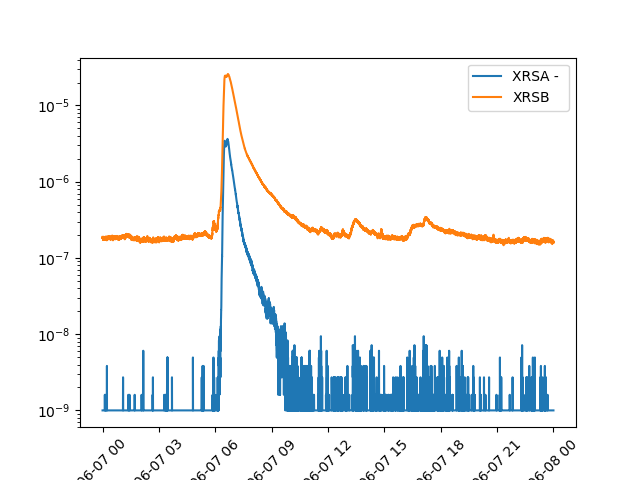

<IPython.core.display.Javascript object>


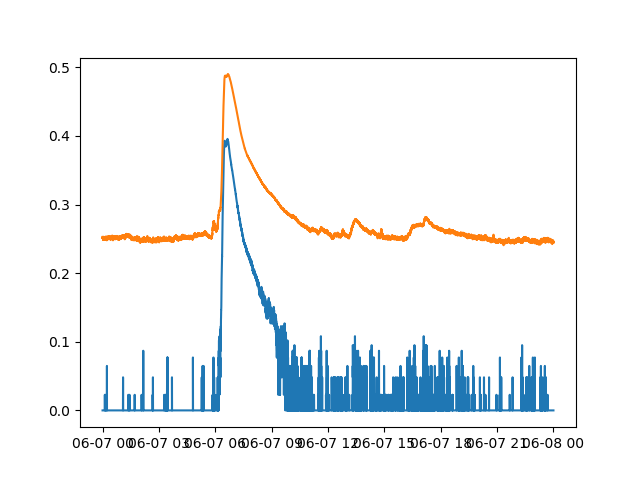

In [5]:
df = goes.data
plt.semilogy(df["xrsa"],label="XRSA - ")
plt.semilogy(df["xrsb"],label="XRSB")
plt.xticks(rotation=45)
plt.legend()
plt.figure()

#Testando logaritmo e normalizacao, que sera util posteriormente....
plt.plot(1.0-np.log(df)/np.log(10.0**-9.0))
plt.show()

## 1.1 Instrumentos de observação
------
Há diversos instrumentos de observação da atividade solar disponíveis. A lista completa de instrumentos está descrita [aqui](https://sdac.virtualsolar.org/cgi/show_details?keyword=INSTRUMENT).

O exemplo abaixo mostra um exemplo de imagem


In [5]:
tr = TimeRange(['2011-06-07 04:00', '2011-06-07 04:01'])
results = Fido.search(a.Time(tr), a.Instrument("aia"))

files = Fido.fetch(results)

/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=44>
  source=self)
/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)


<IPython.core.display.Javascript object>


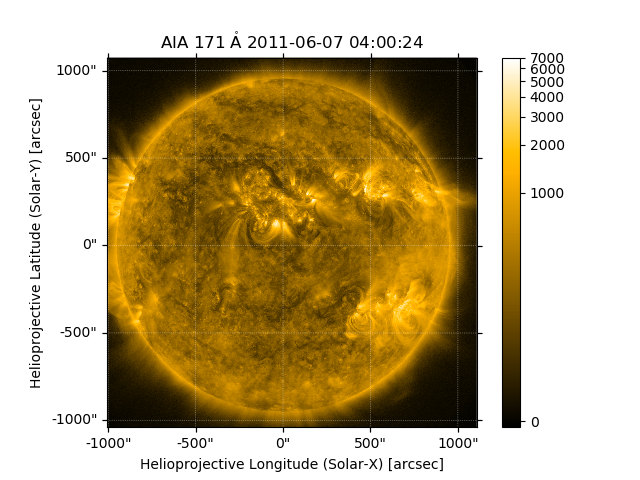

In [6]:
img = sunpy.map.Map(files[0])
img.peek()

-----
## 1.2 Catálogo de explosões solares

Há diversos catálogos de explosões solares, cada um com um conjunto de propriedades diferentes. O catálogo do projeto [Hinode](https://hinode.isee.nagoya-u.ac.jp/flare_catalogue/) foi utilizado neste projeto.

Para simplificar o problema, uma versão csv do catálogo foi salva na pasta 'data/Hinode_Flare_Catalogue.csv'. Este catálogo é constantemente atualizado, e portanto, é interessante sempre atualizar o arquivo.

In [2]:
catalogo = pd.read_csv("data/Hinode_Flare_Catalogue.csv", sep = ",",engine="python")
catalogo

,Event number,start,peak,end,AR location,X-ray class,FG,SP,XRT,EIS,DARTS,RHESSI,Suzaku/WAM,NoRH
0,160620,2017/09/06 11:53,2017/09/06 12:02,2017/09/06 12:10,S09W34,X9.3,0,6,158,7,NaN,50-100,NaN,NaN
1,2750,2006/12/05 10:18,2006/12/05 10:35,2006/12/05 10:45,S06E59,X9.0,0,0,0,0,NaN,25-50,4.820000e+02,NaN
2,161170,2017/09/10 15:35,2017/09/10 16:06,2017/09/10 16:31,S08W88,X8.2,0,0,315,6,NaN,100-300,NaN,NaN
3,41780,2011/08/09 07:48,2011/08/09 08:05,2011/08/09 08:08,N14W69,X6.9,0,0,59,0,NaN,25-50,1.822000e+03,NaN
4,2960,2006/12/06 18:29,2006/12/06 18:47,2006/12/06 19:00,S05E57,X6.5,30,1,0,0,NaN,300-800,4.860000e+02,NaN
5,55910,2012/03/07 00:02,2012/03/07 00:24,2012/03/07 00:40,N18E31,X5.4,6,10,296,0,NaN,no,1.976000e+03,NaN
6,99830,2014/02/25 00:39,2014/02/25 00:49,2014/02/25 01:03,S12E82,X4.9,0,0,0,0,NaN,12-25,NaN,20140225_0043
7,3680,2006/12/13 02:14,2006/12/13 02:40,2006/12/13 02:57,S07W22,X3.4,44,1,44,1,NaN,100-300,4.930000e+02,20061213_0247
8,92040,2013/11/05 22:07,2013/11/05 22:12,2013/11/05 22:15,S12E46,X3.3,0,0,0,0,NaN,no,1.311052e+11,NaN
9,83010,2013/05/14 00:00,2013/05/14 01:11,2013/05/14 01:20,N08E77,X3.2,0,0,102,0,NaN,12-25,NaN,20130514_0107


## 2. Análise  exploratória
-------
Antes de realizar a limpeza dos dados, é interessante avaliar a distribuição dos dados. 
Mesmo que não tenha relação a física Solar, algumas perguntas relacionadas a observação surgiram:  

    a) Há uma época do ano com ocorrência maior evento solar? 
    b) Há algum horário em que ocorre um número maior de eventos? Se sim, de qual classe de evento?
    c) Quais eventos são mais frequentes?
    d) Quanto tempo demora do inicio até o ápice do evento solar?
    e) Quanto tempo demora para cessar um evento solar?
    f) Qual a duração média de um evento?
    

O código a seguir procura responder estas perguntas...


In [7]:
# Formatando colunas para facilitar manipulacao:
dformat = "%Y/%m/%d %H:%M"
catalogo["peakDT"] = catalogo["peak"].apply(lambda x: datetime.strptime(x,dformat))
catalogo["startDT"] = catalogo["start"].apply(lambda x: datetime.strptime(x,dformat))
catalogo["endDT"] = catalogo["end"].apply(lambda x: datetime.strptime(x,dformat))
xevents = catalogo[catalogo['X-ray class'].str.contains('X')]

<IPython.core.display.Javascript object>


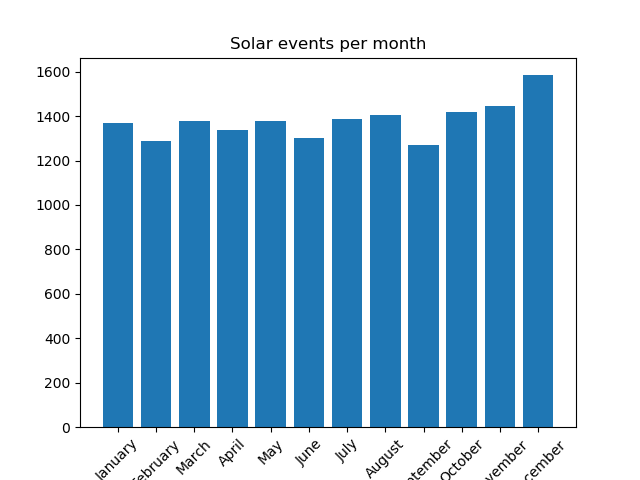

<IPython.core.display.Javascript object>


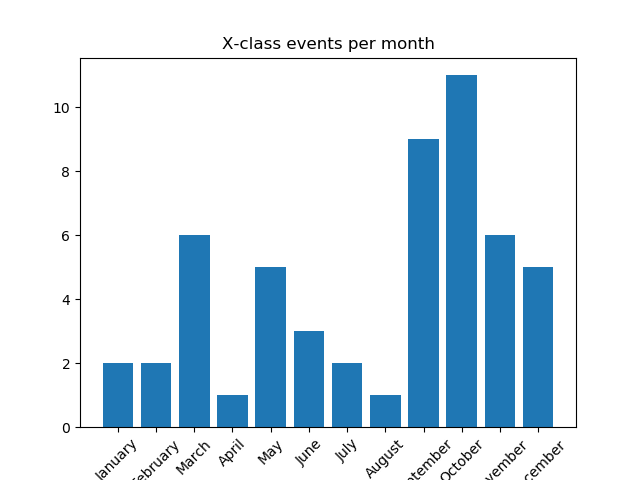

In [8]:
#Questao a)
# fonte: https://stackoverflow.com/questions/27365467/can-pandas-plot-a-histogram-of-dates
monthQuery = catalogo.groupby(catalogo["peakDT"].dt.month).count()
xMonthQuery = xevents.groupby(xevents["peakDT"].dt.month).count()

#assumindo que os meses estao ordenados:
plt.figure()
plt.bar(calendar.month_name[1:13], monthQuery["peakDT"])
plt.xticks(rotation=45)
plt.title("Solar events per month")

plt.figure()
plt.bar(calendar.month_name[1:13], xMonthQuery["peakDT"])
plt.xticks(rotation=45)
plt.title("X-class events per month")

plt.show()



<IPython.core.display.Javascript object>


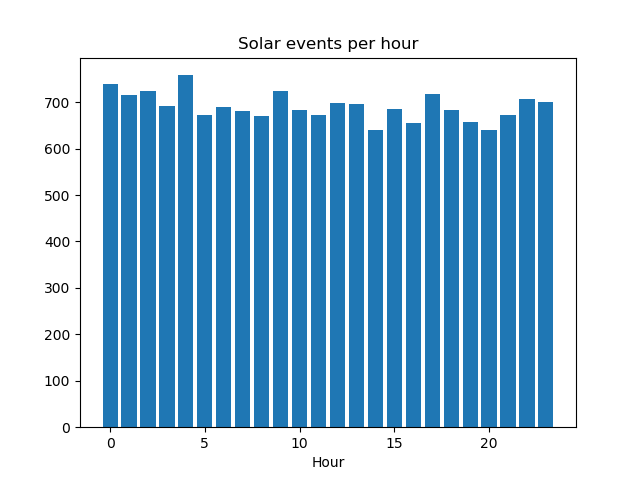

In [9]:
#Questao b)
plt.figure()
hourQuery = catalogo.groupby(catalogo["peakDT"].dt.hour).count()
plt.bar(np.arange(len(hourQuery["peakDT"])), hourQuery["peakDT"])
plt.xlabel("Hour")
plt.title("Solar events per hour")
plt.show()


<IPython.core.display.Javascript object>


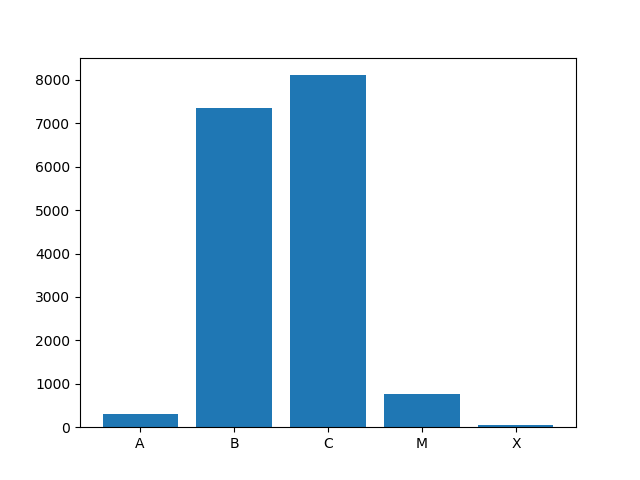

In [10]:
#Questao c)
plt.figure()
catalogo["generalClass"] = catalogo['X-ray class'].apply(lambda x: x[0])
classQuery = catalogo.groupby(catalogo['generalClass']).count()
classQuery["Event number"]
plt.bar(classQuery.index,classQuery["Event number"])
plt.show()


Tempo para iniciar um evento:
count                     16566
mean     0 days 00:11:12.857660
std      0 days 00:17:55.514304
min           -1 days +23:56:00
25%             0 days 00:04:00
50%             0 days 00:06:00
75%             0 days 00:11:00
max             0 days 10:22:00
Name: time2StartEvent, dtype: object

Tempo para finalizar um evento:
count                     16566
mean     0 days 00:10:43.629119
std      0 days 00:21:33.980309
min           -1 days +22:37:00
25%             0 days 00:04:00
50%             0 days 00:06:00
75%             0 days 00:11:00
max             1 days 00:15:00
Name: time2EndEvent, dtype: object

Coisas bizarras que nao deviam acontecer (tempo negativo):
	Picos antes do inicio evento: 2
	Picos após fim do evento: 17
	Total: 19

       Event number             start              peak               end  \
75           112550  2014/10/02 18:49  2014/10/02 19:14  2014/10/02 19:01   
130          112410  2014/09/28 02:39  2014/09/28 03:19  2014/09

<IPython.core.display.Javascript object>


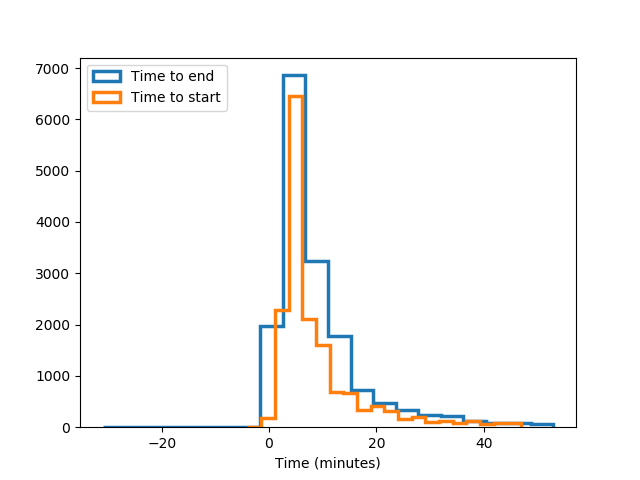

In [11]:
#Questao d) e e)
catalogo["time2StartEvent"] =  catalogo["peakDT"] - catalogo["startDT"] 
catalogo["time2EndEvent"] =  catalogo["endDT"] - catalogo["peakDT"] 
print("Tempo para iniciar um evento:")
print(catalogo["time2StartEvent"].describe())
print("\nTempo para finalizar um evento:")
print(catalogo["time2EndEvent"].describe())

def converteMinutos(temp):
    temp = temp.dt.total_seconds()/60
    avg, std = temp.mean(),  temp.std()
    temp = temp[temp<avg+2*std]
    temp = temp[temp>avg-2*std]
    return temp

endingMinutes = converteMinutos(catalogo["time2EndEvent"])
startingMinutes = converteMinutos(catalogo["time2StartEvent"])

if(len(endingMinutes[endingMinutes<0])>0 or len(startingMinutes[startingMinutes<0])>0):
    print("\nCoisas bizarras que nao deviam acontecer (tempo negativo):")
    neg = endingMinutes[endingMinutes<0].index.values.tolist()
    neg = neg + startingMinutes[startingMinutes<0].index.values.tolist()
    print("\tPicos antes do inicio evento: "+str(len(startingMinutes[startingMinutes<0])))
    print("\tPicos após fim do evento: "+str(len(endingMinutes[endingMinutes<0])))
    print("\tTotal: "+str(len(neg))+"\n")
    print(catalogo.iloc[neg])

plt.figure()
plt.hist(endingMinutes,bins = 20, histtype='step',lw=2.5,label="Time to end")
plt.hist(startingMinutes,bins = 20, histtype='step',lw=2.5,label="Time to start")
plt.xlabel("Time (minutes)")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


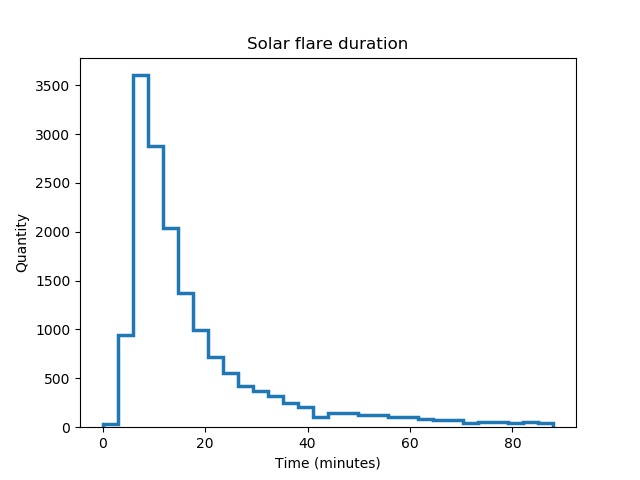

<IPython.core.display.Javascript object>


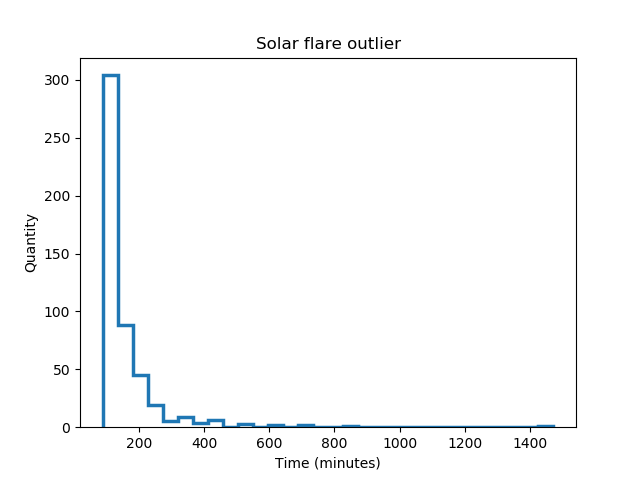

In [12]:
#Questao f)
catalogo["duration"] = catalogo["endDT"] - catalogo["startDT"] 
duration = catalogo["duration"].dt.total_seconds()/60
plt.figure()
avg, std = duration.mean(),  duration.std()
outlier = duration[duration>=avg+2*std]
duration = duration[duration<avg+2*std]
plt.hist(duration,bins = 30, histtype='step',lw=2.5)
plt.title("Solar flare duration")
plt.xlabel("Time (minutes)")
plt.ylabel("Quantity")
plt.figure()
plt.title("Solar flare outlier")
plt.xlabel("Time (minutes)")
plt.ylabel("Quantity")
plt.hist(outlier, bins= 30, histtype='step',lw=2.5)
plt.show()

outlierIdx = outlier.index.values.tolist()

#para listar os outliers: (veja que há outliers de todas as classes)
#catalogo.iloc[outlierIdx]

#Para ver a data mais recente de outlier:(06/2018)
# max(catalogo.iloc[outlierIdx]["peakDT"])


### Conclusão da análise exploratória

A análise exploratória elucidou algumas dúvidas e gerou outras dúvidas.

Como esperado, não é observado um ciclo na escala de tempo meses e horas (questões 'a' e 'b'). Há, no entanto, uma diferença quando tratamos de explosões da classe X. Porém, a heterogeneidade de ocorrências durante os meses pode ser explicada pelo baixo número de observações desta classe de evento (ver questão 'c').

Em relação ao tempo de ocorrência (questões 'd' e 'e'), tanto para iniciar, quanto para finalizar um evento, demora em média 10 minutos. Porém, um dado estranho foi observado. Há 2 ocorrências onde o ápice do evento ocorre antes do inicio do evento, e 17 ocorrência em que o ápice  do evento ocorre após o fim do evento. Uma análise mais detalhada com alguma técnica de classificação do período de explosões, como o módulo 'hek' da biblioteca sunpy. Felizmente, nenhum dos casos de falha pertencem a classe X. 

--------


## 2.1 Limpeza
-------

Trataremos de séries temporais de explosões da classe X. Muita informação não é util para a análise, e portanto será descartada.  

In [3]:
tidy = catalogo[['start','peak', 'end','X-ray class']] 
tidy = tidy.rename(columns={"X-ray class":"class"})
tidy = tidy[tidy['class'].str.contains('X')]

In [4]:
# Download das series temporais:
def getDataFrameTimeSeries(dataFrame):
    linha = []
    nDataFrame = dataFrame.copy()
    nDataFrame["timeSeries"] = np.nan
    nDataFrame = nDataFrame.astype(np.object)
    scaleFactor = np.sqrt(2.0)
    for idx, elem in nDataFrame.iterrows():
        t = TimeRange([elem["start"], elem["end"]])
        # Soft and Hard X ray data fetch:
        res = Fido.search(a.Time(t), a.Instrument('XRS'))
        files = Fido.fetch(res)
        ts = TimeSeries(files)
        
        # porque nao utilizaram exceptions para informar a falta de um dado?
        if(len(files)==0):
            continue
        # quando ha mais de um arquivo:
        if(len(files)>1):
            timeSeriesData = ts[0].data
            for i in range(1,len(ts)):
                timeSeriesData = pd.concat([timeSeriesData,ts[i].data])
            # normalizando -> 1.0-np.log(df)/np.log(10.0**-9.0)
            nDataFrame.at[idx,"timeSeries"] = scaleFactor*(1.0 - np.log(timeSeriesData)/np.log(10.0**-9.0))
            nDataFrame.at[idx,"timeSeries"] = nDataFrame.at[idx,"timeSeries"].replace([np.inf, -np.inf], np.nan)
            if(nDataFrame.at[idx,"timeSeries"].isnull().any().any()):
                nDataFrame.at[idx,"timeSeries"] = np.nan
        #caso padrao
        else:
            # normalizando -> 1.0-np.log(df)/np.log(10.0**-9.0)
            nDataFrame.at[idx,"timeSeries"] = scaleFactor*(1.0 - np.log(ts.data)/np.log(10.0**-9.0))
            nDataFrame.at[idx,"timeSeries"] = nDataFrame.at[idx,"timeSeries"].replace([np.inf, -np.inf], np.nan)
            if(nDataFrame.at[idx,"timeSeries"].isnull().any().any()):
                nDataFrame.at[idx,"timeSeries"] = np.nan
        #vericiando erros na serie temporal, infelizmente sera descartado caso exist
    return nDataFrame
tidy = getDataFrameTimeSeries(tidy)
    

/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/header.py:1171: ResourceWarning: unclosed <socket.socket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60802), raddr=('198.118.248.134', 443)>
  self._keyword_indices[keyword].append(idx)
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=57>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python

/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/util.py:193: ResourceWarning: unclosed <socket.socket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60804), raddr=('198.118.248.134', 443)>
  for sub in sorted(subs, key=operator.attrgetter('__name__')):
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=57>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/base.py:434: ResourceWarning: unclosed <socket.socket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60806), raddr=('198.118.248.134', 443)>
  if Parameter.VAR_KEYWORD not in (x.kind for x in sig.parameters.values()):
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=57>
  source=self)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/config/configuration.py:547: ResourceWarning: unclosed <socket.socket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60808), raddr=('198.118.248.134', 443)>
  return cobj[secname]
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=57>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/site-packages

/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/config/configuration.py:547: ResourceWarning: unclosed <socket.socket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60810), raddr=('198.118.248.134', 443)>
  return cobj[secname]
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=57>
  source=self)
/home/rubens/anaconda3/lib/python3.7/funct

/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/config/configuration.py:547: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60812), raddr=('198.118.248.134', 443)>
  return cobj[secname]
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/config/configuration.py:547: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60814), raddr=('198.118.248.134', 443)>
  return cobj[secname]
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/inspect.py:2800: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60816), raddr=('198.118.248.134', 443)>
  for param in parameters))
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/header.py:1171: ResourceWarning: unclosed <socket.socket fd=58, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60822), raddr=('198.118.248.134', 443)>
  self._keyword_indices[keyword].append(idx)
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=58>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/util.py:193: ResourceWarning: unclosed <socket.socket fd=58, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60824), raddr=('198.118.248.134', 443)>
  for sub in sorted(subs, key=operator.attrgetter('__name__')):
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=58>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/base.py:434: ResourceWarning: unclosed <socket.socket fd=58, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60826), raddr=('198.118.248.134', 443)>
  if Parameter.VAR_KEYWORD not in (x.kind for x in sig.parameters.values()):
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=58>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/inspect.py:2800: ResourceWarning: unclosed <socket.socket fd=58, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60828), raddr=('198.118.248.134', 443)>
  for param in parameters))
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=58>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: Ru

/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/config/configuration.py:547: ResourceWarning: unclosed <socket.socket fd=58, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60830), raddr=('198.118.248.134', 443)>
  return cobj[secname]
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=58>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/enum.py:310: ResourceWarning: unclosed <socket.socket fd=58, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60832), raddr=('198.118.248.134', 443)>
  return cls.__new__(cls, value)
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=58>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=54>
  source=self)
/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/header.py:1171: ResourceWarning: unclosed <socket.socket fd=58, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60834), raddr=('198.118.248.134', 443)>
  self._keyword_indices[keyword].append(idx)
/home/rubens/anaconda3/li

/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/card.py:540: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60836), raddr=('198.118.248.134', 443)>
  card = cls()
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/config/configuration.py:547: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60838), raddr=('198.118.248.134', 443)>
  return cobj[secname]
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/site-packages

/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/config/configuration.py:547: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60840), raddr=('198.118.248.134', 443)>
  return cobj[secname]
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/config/configuration.py:547: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60842), raddr=('198.118.248.134', 443)>
  return cobj[secname]
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/util.py:193: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60844), raddr=('198.118.248.134', 443)>
  for sub in sorted(subs, key=operator.attrgetter('__name__')):
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anac

/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/config/configuration.py:547: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60846), raddr=('198.118.248.134', 443)>
  return cobj[secname]
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/site-packages

/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/card.py:540: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60848), raddr=('198.118.248.134', 443)>
  card = cls()
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/header.py:1171: ResourceWarning: unclosed <socket.socket fd=60, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60854), raddr=('198.118.248.134', 443)>
  self._keyword_indices[keyword].append(idx)
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=60>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/enum.py:310: ResourceWarning: unclosed <socket.socket fd=60, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60856), raddr=('198.118.248.134', 443)>
  return cls.__new__(cls, value)
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=60>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=56>
  source=self)
/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/inspect.py:2800: ResourceWarning: unclosed <socket.socket fd=60, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60858), raddr=('198.118.248.134', 443)>
  for param in parameters))
/home/rubens/anaconda3/lib/python3.7/asynci

/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/card.py:540: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60860), raddr=('198.118.248.134', 443)>
  card = cls()
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/base.py:434: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60862), raddr=('198.118.248.134', 443)>
  if Parameter.VAR_KEYWORD not in (x.kind for x in sig.parameters.values()):
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/util.py:193: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60864), raddr=('198.118.248.134', 443)>
  for sub in sorted(subs, key=operator.attrgetter('__name__')):
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anac

/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/config/configuration.py:547: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60866), raddr=('198.118.248.134', 443)>
  return cobj[secname]
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/util.py:193: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60868), raddr=('198.118.248.134', 443)>
  for sub in sorted(subs, key=operator.attrgetter('__name__')):
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/card.py:540: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60870), raddr=('198.118.248.134', 443)>
  card = cls()
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/config/configuration.py:547: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60872), raddr=('198.118.248.134', 443)>
  return cobj[secname]
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/site-packages

/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/config/configuration.py:547: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60874), raddr=('198.118.248.134', 443)>
  return cobj[secname]
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/site-packages

/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/config/configuration.py:547: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60876), raddr=('198.118.248.134', 443)>
  return cobj[secname]
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/site-packages

/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/config/configuration.py:547: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60878), raddr=('198.118.248.134', 443)>
  return cobj[secname]
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/util.py:197: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60880), raddr=('198.118.248.134', 443)>
  for sub in itersubclasses(sub, _seen):
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/sit

/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/config/configuration.py:547: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60882), raddr=('198.118.248.134', 443)>
  return cobj[secname]
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/util.py:197: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60884), raddr=('198.118.248.134', 443)>
  for sub in itersubclasses(sub, _seen):
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/base.py:434: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60886), raddr=('198.118.248.134', 443)>
  if Parameter.VAR_KEYWORD not in (x.kind for x in sig.parameters.values()):
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/inspect.py:2800: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60888), raddr=('198.118.248.134', 443)>
  for param in parameters))
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/card.py:540: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60890), raddr=('198.118.248.134', 443)>
  card = cls()
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/util.py:197: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60892), raddr=('198.118.248.134', 443)>
  for sub in itersubclasses(sub, _seen):
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/util.py:197: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60894), raddr=('198.118.248.134', 443)>
  for sub in itersubclasses(sub, _seen):
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/sit

/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/util.py:197: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60896), raddr=('198.118.248.134', 443)>
  for sub in itersubclasses(sub, _seen):
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/inspect.py:2800: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60898), raddr=('198.118.248.134', 443)>
  for param in parameters))
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/io/fits/util.py:197: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60900), raddr=('198.118.248.134', 443)>
  for sub in itersubclasses(sub, _seen):
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/sit

/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/site-packages/astropy/config/configuration.py:547: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60902), raddr=('198.118.248.134', 443)>
  return cobj[secname]
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/inspect.py:2800: ResourceWarning: unclosed <socket.socket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.95', 60904), raddr=('198.118.248.134', 443)>
  for param in parameters))
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=53>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


### Atributos faltantes
-----
Algumas séries temporais foram perdidas, há também casos onde falta apenas um instante da série. Outros casos, a série é zerada até o evento pois a magnitude do evento é muito alta.

Remover completamente a série temporal é uma solução tacanha. Porém analisar o caso de uma imprecisão local seria complicado, seria necessário determinar um limiar, interpolar o ponto e verificar se a aproximação não afeta a análise. Além disso, foram observados poucos casos de imprecisão.

In [5]:
tidy = tidy.dropna()

In [6]:
tidy["timeSeries"].iloc[:].count()

31

### Análise exploratótia das séries temporais

A séries temporais obtidas apresentam alta resolução temporal, uma questão interessante a ser avaliada é o grau de amostragem da série. O principal motivo para realizar tal amostragem é o que será ensinado a rede neural (seção 3). Quando dividido uma série temporal de alta resolução, pouca informação sobre a flutuação é preservada em cada segmento da série.

Em processamento digital de sinais, o Teorema de Nyquist determina que para observar um fenômeno em uma frequência é necessário amostrar uma série com uma frequência maior, afim de evitar distorções [(Nyquist, H.; 2002)](https://web.archive.org/web/20060706192816/http://www.loe.ee.upatras.gr/Comes/Notes/Nyquist.pdf). Na prática, em geral é utilizado o dobro da frequência para amostrar a série temporal. 

Como observado nos testes anteriores, um evento solar dura em média 10 minutos, sendo 5 minutos para o inicio e 5 minutos para o término do evento. Para a série temporal do problema, a amostragem a cada 70 pontos equivale a aproximadamente 2.4 minutos, que é aproximadamente metade do tempo de amostral esperado.    

Para verificar a validade do teste, foi selecionado uma série temporal e aplicado a transformada de Fourier para obter o espaço de frequência. Também foi medido a média do módulo do gradiente com diferentes passos de tempo.


In [53]:
def gradientTest(serie, gradMin, gradMax):
    output = []
    for i in range(gradMin,gradMax):
        grad = np.mean(np.abs(serie - np.roll(serie,i+1))/(i+1))
        output.append(grad)
    return output
    

<IPython.core.display.Javascript object>


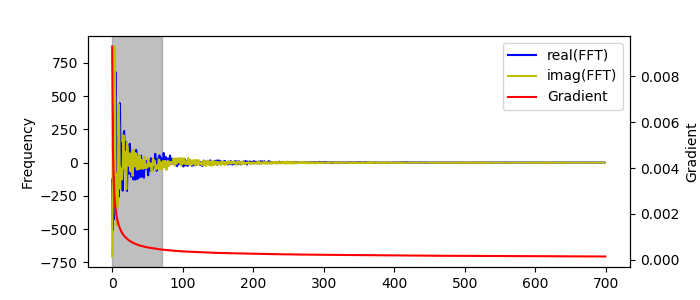

In [78]:
test = tidy["timeSeries"].iloc[0]

xrsaFFT = fft(test.xrsa.values)
xrsbFFT = fft(test.xrsb.values)

maxWindow = 700

gradAvgSerie = gradientTest(test.xrsa.values,0,maxWindow)

plt.figure(figsize=(7,3))

plt.title("")
plt.axvspan(0,70, color='gray', alpha=0.5)

plt.ylabel("Frequency")
p1 = plt.plot(np.real(xrsbFFT[1:maxWindow]),label="real(FFT)",color='b')
p2 = plt.plot(np.imag(xrsbFFT[1:maxWindow]),label="imag(FFT)",color='y')

plt.twinx()
p3 = plt.plot(gradAvgSerie,color='r',label="Gradient")
plt.ylabel("Gradient")

legend = p1+p2+p3
plt.legend(legend,[ln.get_label() for ln in legend])
plt.show()


O código abaixo reamostra a série temporal a cada 70 passos de tempo, e plota o mesmo gráfico.

Sampling every: 0 days 00:02:23.360000


<IPython.core.display.Javascript object>


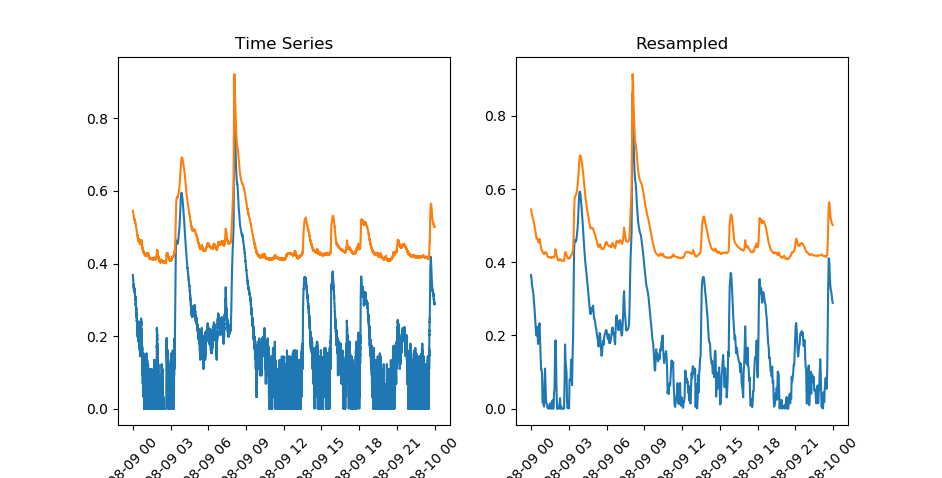

In [84]:
def reSample(data, step):
    timeStep = data.index[step]-data.index[0]
    print("Sampling every:",timeStep)
    return data.resample(rule=timeStep).mean()

newTimeSeries = reSample(test,70)

plt.figure(figsize=(7,4))
plt.subplot(1,2,1)
plt.title("Time Series")
plt.plot(test)
plt.xticks(rotation=45)
plt.subplot(1,2,2)
plt.title("Resampled")
plt.plot(newTimeSeries)
plt.xticks(rotation=45)
plt.show()

Outra questão a ser avaliada, é a correlação as séries xrsa e xrsb. As séries temporais apresentam flutuações similares. A análise com apenas um destes sinais não é suficiente?

O gráfico a seguir mostra a correlação entre os dois sinais.

<IPython.core.display.Javascript object>


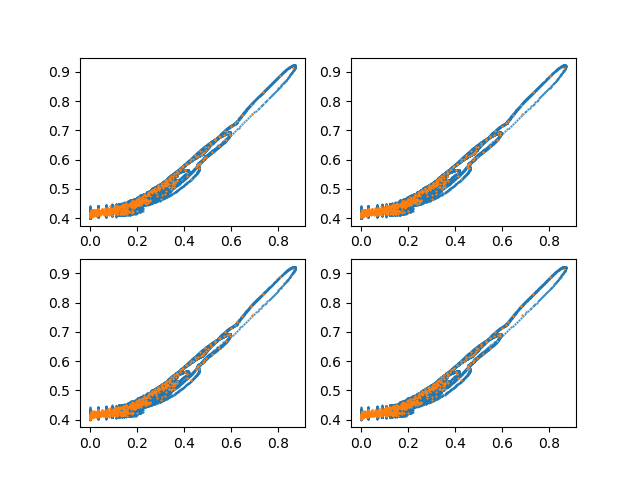

In [109]:
plt.figure()
plt.subplot(2,2,1)
plt.plot(test.xrsa,test.xrsb, '.',markersize=1)
plt.plot(newTimeSeries.xrsa,newTimeSeries.xrsb, '*',markersize=1)
plt.subplot(2,2,2)
plt.plot(test.xrsa,test.xrsb, '.',markersize=1)
plt.plot(newTimeSeries.xrsa,newTimeSeries.xrsb, '*',markersize=1)
plt.subplot(2,2,3)
plt.plot(test.xrsa,test.xrsb, '.',markersize=1)
plt.plot(newTimeSeries.xrsa,newTimeSeries.xrsb, '*',markersize=1)
plt.subplot(2,2,4)
plt.plot(test.xrsa,test.xrsb, '.',markersize=1)
plt.plot(newTimeSeries.xrsa,newTimeSeries.xrsb, '*',markersize=1)


plt.show()

# 3. Prevendo explosões da classe X
---------------------------
Prever a ocorrência de explosões solares é um desafio. Em geral é analisado estatisticamente um conjunto de dados composto por imagens, séries temporais (raio X, gamma, ...) e o número de ocorrência de eventos em um período anterior. Um exemplo disto é mostrado por 

Outra abordagem é a previsão do evento através da análise de um conjunto de séries temporais medidas. Tipicamente utiliza-se um classificador com memória de curto prazo (Short-term memory), um exemplo de uso desta abordagem é mostrado por [Liu, et. al(2019)](https://arxiv.org/pdf/1905.07095.pdf). Esta abordagem é eficiente para previsão de eventos solares, alcançando ~93% de acurácia para classificar explosões entre as classes C e M. Uma explicação informal, porém mais detalhada em relação a técnica, está disponível [aqui](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

O código abaixo demonstra o uso de LSTM, um tipo de rede neural recorrente, que replica a dinâmica da série temporais. Há diversas ferramentas que implementam LSTMs, o modelo apresentado neste trabalho é inspirado em um modelo de [previsão meteorológica](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb). Perceba que o objetivo é diferente do apresentado por [Liu, et. al(2019)](https://arxiv.org/pdf/1905.07095.pdf), pois não é de interesse determinar qual classe de evento ocorreu. Neste trabalho o classificador prevê a amplitude do sinal de raio-X em um passo de tempo, para determinar se ocorrerá um evento solar.

In [11]:
model = Sequential()

#numero total de pontos na entrada e saida de dados 
serie_size = 32
number_series = 2

#Apenas uma camada para inicio:
model.add(LSTM(units=int(1.5*serie_size),return_sequences=True,input_shape=(serie_size, number_series),dtype=np.float))
model.add(LSTM(units=int(serie_size),return_sequences=True,dtype=np.float))
model.add(Dropout(0.15))
#model.add(GRU(units=100,return_sequences=False))
model.add(Dense(number_series, activation='sigmoid'))

W0818 09:14:53.352169 139734185047872 deprecation.py:506] From /home/rubens/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=44>
  source=self)
/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: Resourc

## 3.1 Compilando a rede
----------------------

Ao compilar o modelo, podemos especificar diversos detalhes relativos ao treinamento do modelo. No exemplo abaixo, compilamos o modelo, especificando o erro quadrático médio como a função de perda e otimizador adam.

In [12]:
model.compile(loss='mean_squared_error', optimizer=SGD())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32, 48)            9792      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 32)            10368     
_________________________________________________________________
dropout (Dropout)            (None, 32, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 32, 2)             66        
Total params: 20,226
Trainable params: 20,226
Non-trainable params: 0
_________________________________________________________________


## 3.2 Gerador de séries
-----

Para treinar a rede é necessário construir um gerador de séries temporais. Neste trabalho selecionamos 40 séries temporais para o treinamento, e procuramos prever as 12 séries restantes do catálogo. Em trabalhos futuros este segmento de código pode ser aprimorado para gerar artificialmente séries temporais, pois, essa abordagem é eficiente para treinar redes neurais profundas.


In [13]:
def batch_generator(trainData, batch_size=10, sequence_length=32):
    """
    Generator function for creating random batches of training-data.
    Adaptado de: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, 2)
        x_batch = np.zeros(shape=x_shape)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, 2)
        y_batch = np.zeros(shape=y_shape)
        
        sample = trainData.sample(batch_size)
        batch_line = 0
        for line, serie in sample.iterrows():
            temp = serie.timeSeries
            pos = np.random.randint(len(temp)-2-sequence_length)
            
            #selecionando aleatoriamente na serie temporal
            x_batch[batch_line,:,0] = temp[pos:pos+sequence_length]["xrsa"].values
            x_batch[batch_line,:,1] = temp[pos:pos+sequence_length]["xrsb"].values
            
            #sera aprendido a sequencia desloacada a um passo de tempo: 
            y_batch[batch_line,:,0] = temp[pos+1:pos+sequence_length+1]["xrsa"].values
            y_batch[batch_line,:,1] = temp[pos+1:pos+sequence_length+1]["xrsb"].values
            batch_line = batch_line + 1
    
        yield (np.float32(x_batch), np.float32(y_batch))

Inicializando as variaveis do modelo para começar o treinamento

In [14]:
gen = batch_generator(tidy,sequence_length=serie_size)
x, y = next(gen)

#batch 0, 3 primeiras linhas...
print(x[0,0:3])
print(y[0,0:3])

[[0.3059558 0.5009724]
 [0.3059558 0.5009724]
 [0.3059558 0.5008573]]
[[0.3059558 0.5009724]
 [0.3059558 0.5008573]
 [0.3059558 0.5008573]]


In [15]:
model.fit_generator(generator=gen,epochs=20,steps_per_epoch=100)

Epoch 1/20


W0818 09:15:58.048067 139734185047872 deprecation.py:323] From /home/rubens/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100/100 [==============================] - 13s 125ms/step - loss: 0.0368
Epoch 2/20
100/100 [==============================] - 7s 73ms/step - loss: 0.0296
Epoch 3/20
100/100 [==============================] - 7s 73ms/step - loss: 0.0242
Epoch 4/20
100/100 [==============================] - 7s 74ms/step - loss: 0.0211
Epoch 5/20
100/100 [==============================] - 7s 74ms/step - loss: 0.0189
Epoch 6/20
100/100 [==============================] - 8s 76ms/step - loss: 0.0176
Epoch 7/20
100/100 [==============================] - 8s 78ms/step - loss: 0.0167
Epoch 8/20
100/100 [==============================] - 8s 79ms/step - loss: 0.0180
Epoch 9/20
100/100 [==============================] - 8s 83ms/step - loss: 0.0150
Epoch 10/20
100/100 [==============================] - 8s 85ms/step - loss: 0.0149
Epoch 11/20
100/100 [==============================] - 8s 82ms/step - loss: 0.0149
Epoch 12/20
100/100 [==============================] - 9s 86ms/step - loss: 0.0145
Epoch 13/20
100/100 [=

### Visualizandoprevisão de série

[[0.3219609  0.5440916 ]
 [0.3219609  0.5441527 ]
 [0.3219609  0.5441527 ]
 [0.3219609  0.5441527 ]
 [0.32264033 0.5441527 ]
 [0.32128078 0.5442748 ]
 [0.32264033 0.5443358 ]
 [0.3219609  0.5443358 ]
 [0.32058755 0.5444599 ]
 [0.32128078 0.5443358 ]
 [0.32058755 0.5442748 ]
 [0.32128078 0.5442748 ]
 [0.32128078 0.5443358 ]
 [0.32058755 0.5442748 ]
 [0.32058755 0.5442748 ]
 [0.32128078 0.5442748 ]
 [0.32128078 0.5443358 ]
 [0.32128078 0.54421383]
 [0.32128078 0.5440916 ]
 [0.32058755 0.54421383]
 [0.3198935  0.5441527 ]
 [0.32128078 0.5441527 ]
 [0.32058755 0.54402804]
 [0.3198935  0.5439668 ]
 [0.32058755 0.5439055 ]
 [0.31919232 0.5439055 ]
 [0.32058755 0.5439055 ]
 [0.31847748 0.5438418 ]
 [0.3198935  0.5437804 ]
 [0.31919232 0.54371893]
 [0.31919232 0.54359585]
 [0.31847748 0.54353184]]
[[0.39285225]
 [0.3685599 ]
 [0.3481006 ]
 [0.3311693 ]
 [0.31732517]
 [0.30609515]
 [0.2970357 ]
 [0.28975272]
 [0.28390968]
 [0.27922893]
 [0.27548152]
 [0.27248228]
 [0.2700812 ]
 [0.2681573 ]
 [0

<IPython.core.display.Javascript object>


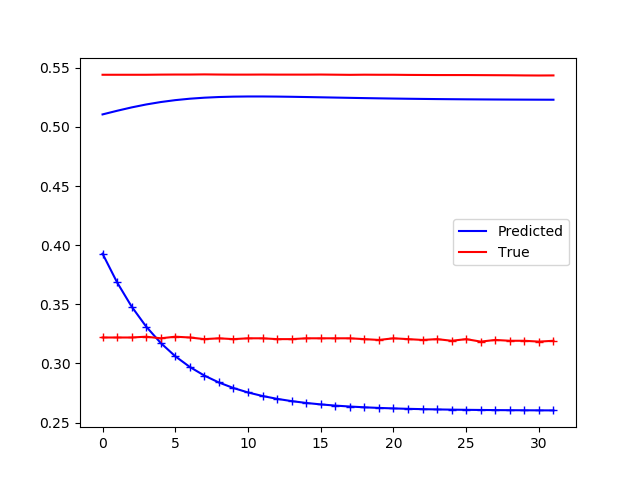

In [29]:
gen = batch_generator(tidy,1,serie_size)
rand = next(gen)
x_test = rand[0]
y_true = rand[1].T

y_test = model.predict(x_test).T


plt.figure()
plt.plot(y_test[0],color='b',marker='+')
plt.plot(y_test[1],color='b',label="Predicted")
plt.plot(y_true[0],color='r',marker='+')
plt.plot(y_true[1],color='r',label="True")
plt.legend()
plt.show()


# 4. Redefinindo o problema
---------------------------

Os artigos citados anteriormente apresentam análise de eventos extremos das classes C e M. Infelizmente eventos da classe X são raros, logo é dificil avaliar o desempenho do preditor. Devido a esse problema, proponho neste trabalho uma terceira abordagem, que aumenta o conjunto de dados disponível ao classificação. 

Definido o conjunto de dados, reescrevemos o problema de previsão conforme os seguintes passos: 
1. Selecionar a série temporal $T_{b}$ anterior ao evento.
2. Dividir a série $T_{b}$ em pedaços.
3. Associar cada pedaço da série a uma distância temporal do evento $D_t$.
4. Realizar medidas associadas ao pedaço de série temporal (Entropia, DFA, Espectro de Singularidade, GSA, ...).
5. Treinar um classificador para prever a distância temporal do evento, dado um pedaço de série temporal.

/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


<IPython.core.display.Javascript object>


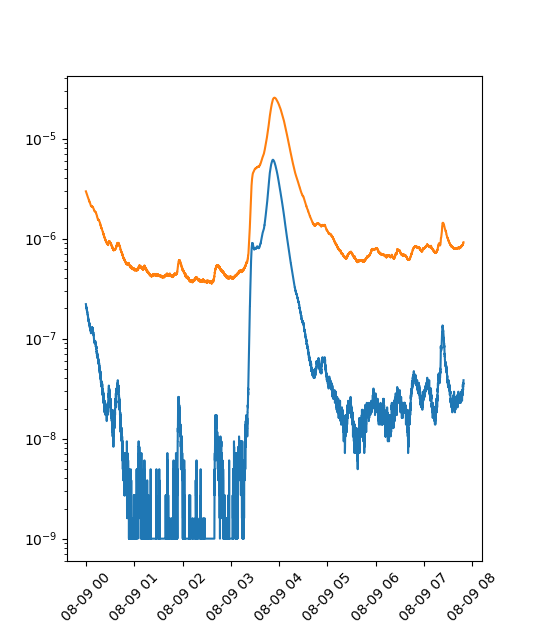

<IPython.core.display.Javascript object>


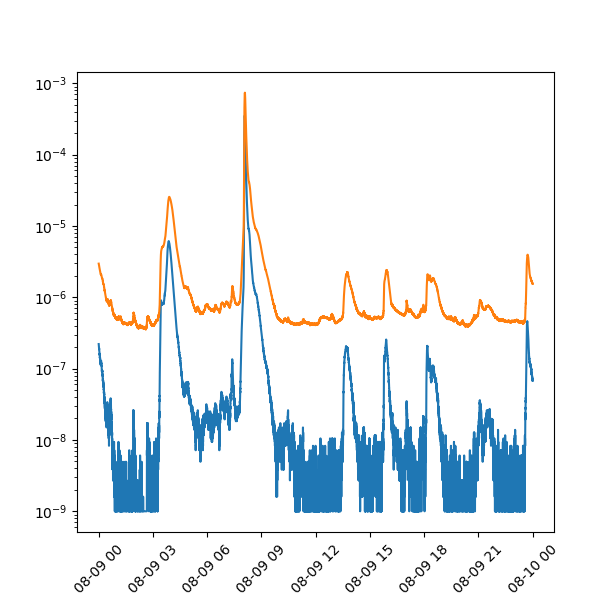

In [18]:
#item 1:
def getTimeSeriesData(elem):
    t = TimeRange([elem["start"], elem["end"]])
    # Soft and Hard X ray data fetch:
    res = Fido.search(a.Time(t), a.Instrument('XRS'))
    files = Fido.fetch(res)
    ts = TimeSeries(files)
    
    pre = ts.data[:elem["start"]]
    start = ts.data[elem["start"]:elem["peak"]]
    end = ts.data[elem["peak"]:elem["end"]]
    pos = ts.data[elem["end"]:]
    return pre, start, end, pos, ts.data

#apenas para testar a funcao.   
pre, start, end, pos, full = getTimeSeriesData(tidy.loc[3])
plt.figure()
plt.semilogy(pre)
plt.xticks(rotation=45)
plt.figure()
plt.semilogy(full)
plt.xticks(rotation=45)
plt.show()